# Horn Schunck Optical Flow
Filipe Barnabé - \
João Ferreira - \
Xavier Verbrugge - 

## Necessary librarires

In [14]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## First approaches to the images (import -> resize)
Since opencv imports images as BGR it is necessary to also convert the images into a gray scale. \
The images (arrays) are converted to float for future work

In [15]:
# Important parameters:
multi_channel = True

In [16]:
def images(path: str, multi_channel: bool, resize_percentage: int = 50) -> np.ndarray:
    img = cv.imread(path)
    if not multi_channel:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = img.astype(np.float32)
    else:
        for i in range(img.shape[2]):
            img[:,:,i] = img[:,:,i].astype(np.float32)
    # width = int(img.shape[1] * resize_percentage/100)
    # height = int(img.shape[0] * resize_percentage/100)
    # img = cv.resize(img, (width, height), interpolation=cv.INTER_AREA)
    
    return img

In [17]:
# gray images
multi_channel = False
img1 = images(path="dataset/eval-data-gray/Army/frame07.png", multi_channel=multi_channel)
img2 = images(path="dataset/eval-data-gray/Army/frame08.png", multi_channel=multi_channel)

In [29]:
# color images
multi_channel = True
img3 = images(path="dataset/other-data-color/Dimetrodon/frame10.png", multi_channel=multi_channel)
img4 = images(path="dataset/other-data-color/Dimetrodon/frame11.png", multi_channel=multi_channel)

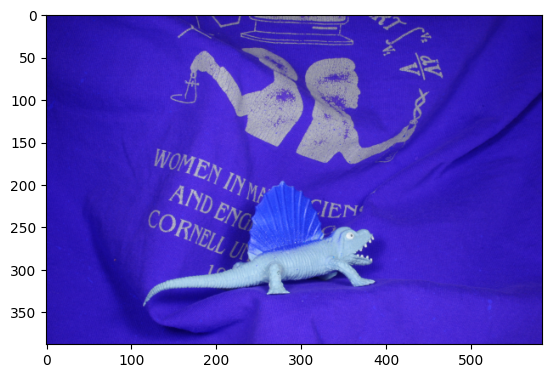

In [19]:
# img3 = cv.imread("dataset/eval-data/Army/frame07.png")
plt.imshow(img3)


In [20]:
img3.shape

(388, 584, 3)

## Defenition of the masks

maskX = 
$\begin{bmatrix}
-1 & 1\\
-1 & 1
\end{bmatrix}$ 

maskY = 
$\begin{bmatrix}
1 & 1\\
-1 & -1
\end{bmatrix}$ 

maskT = 
$\begin{bmatrix} 
1 & 1\\
1 & 1
\end{bmatrix}$

**Laplacian Mask**

maksHS = 
$\begin{bmatrix} 
\frac{1}{12} & \frac{1}{6} & \frac{1}{12}\\[6pt]
\frac{1}{6} & -1 & \frac{1}{6}\\[6pt]
\frac{1}{12} & \frac{1}{6} & \frac{1}{12}
\end{bmatrix}$

In [30]:
# Laplace kernel 
hs_kernel = np.array(
    [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
)
# X, Y, T kernel
kernelX = np.array([[-1,1],[-1,1]]) * 0.25
kernelY = np.array([[1,1],[-1,-1]]) * 0.25
kernelT = np.ones((2,2)) * 0.25

In [31]:
# Derivatives computation
def derivatives_computation(img1: np.ndarray, img2: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    fx = cv.filter2D(img1, -1, cv.flip(kernelX, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(kernelX, -1), borderType=cv.BORDER_CONSTANT)
    fy = cv.filter2D(img1, -1, cv.flip(kernelY, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(kernelY, -1), borderType=cv.BORDER_CONSTANT)
    ft = cv.filter2D(img1, -1, cv.flip(kernelT, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(-kernelT, -1), borderType=cv.BORDER_CONSTANT)
    
    return fx, fy, ft

In [32]:
def sigle_multi_channel_derivatives(multi_channel: bool, img1:np.ndarray, img2= np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if multi_channel:
        fx, fy, ft = [np.zeros(shape=(img1.shape[0], img1.shape[1])) for _ in range(3)] 
        for i in range(img1.shape[2]):
            [fx_c, fy_c, ft_c] = derivatives_computation(img1=img1[:,:,i], img2=img2[:,:,i])
            fx = fx + fx_c
            fy = fy + fy_c
            ft = ft + ft_c
    else:
        [fx, fy, ft] = derivatives_computation(img1=img1, img2=img2)
    return fx, fy, ft

In [33]:
[fx, fy, ft] = sigle_multi_channel_derivatives(multi_channel, img1=img3, img2=img4)

In [25]:
# [fx, fy, ft] = derivatives_computation(img1=img1, img2=img2)

In [34]:
# Initialize the velocities as zeros (u and v)
images_shape = img3.shape
u = np.zeros(shape=(images_shape[0], images_shape[1]), dtype=np.float32)
v = np.zeros(shape=(images_shape[0], images_shape[1]), dtype=np.float32)

In [35]:
alpha = 0.001
for _ in range(1000):
    # Computation of the local average
    uAvg = cv.filter2D(u, -1, cv.flip(hs_kernel, -1), borderType=cv.BORDER_CONSTANT)
    vAvg = cv.filter2D(v, -1, cv.flip(hs_kernel, -1), borderType=cv.BORDER_CONSTANT)

    der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)

    u = uAvg - fx * der
    v = vAvg - fy * der

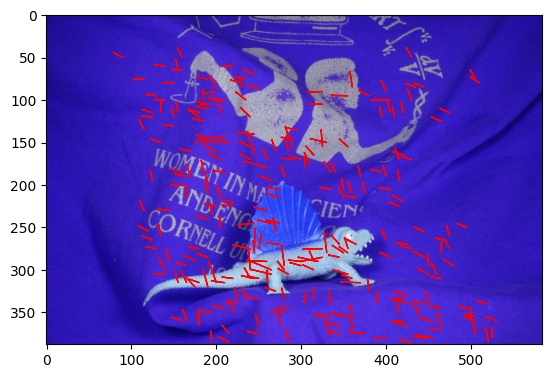

In [37]:
quivstep = 5
scale = 0.04
fn = None
ax = plt.figure().gca()
ax.imshow(img3, cmap="gray", origin="upper")

# plt.scatter(POI[:,0,1],POI[:,0,0])
for i in range(0, u.shape[0], quivstep):
    for j in range(0, v.shape[1], quivstep):
        arrow = np.sqrt(u[i,j]**2+v[i,j]**2)
        if arrow > 300:
            ax.arrow(
                j,
                i,
                v[i, j] * scale,
                u[i, j] * scale,
                color="red",
                head_width=1.5,
                head_length=1,
            )

plt.draw()
plt.pause(0.01)

In [56]:
type(v)

numpy.ndarray

In [42]:
from src.lk_hs.horn_shunck import hs

img1 = "dataset/other-data-color/Dimetrodon/frame10.png"
img2 = "dataset/other-data-color/Dimetrodon/frame11.png"

u, v = hs(img_t=img1, img_t1=img2, multi_channel=True)

In [4]:
from src.evaluation.end_point_error import calc_MEPE_directory

mepe, sdEpe = calc_MEPE_directory("Dimetrodon", u, v)

In [5]:
from src.evaluation.angular_error import calc_AAE_directory

mang, sdAngular = calc_AAE_directory("Dimetrodon", u, v)

In [11]:
from src.lk_hs.horn_shunck import hs
from src.evaluation.end_point_error import calc_MEPE_directory
from src.evaluation.angular_error import calc_AAE_directory

import os
folders = os.listdir('ground_truth_flow')

In [13]:
for i in folders:
    img1 = f"dataset/other-data-color/{i}/frame10.png"
    img2 = f"dataset/other-data-color/{i}/frame11.png" 

    u, v = hs(img_t=img1, img_t1=img2, multi_channel=True)

    mepe, sdEpe = calc_MEPE_directory(i, u, v)

    mang, sdAngular = calc_AAE_directory(i, u, v)

    print(i)
    print(f"mepe: {mepe}, sdEpe: {sdEpe}")
    print(f"mang: {mang}, sdAngular: {sdAngular}")

Urban3
mepe: 108.52, sdEpe: 132.46
mang: -0.53, sdAngular: 0.46
Urban2
mepe: 66.36, sdEpe: 48.94
mang: 0.11, sdAngular: 0.5
Venus
mepe: 68.24, sdEpe: 63.95
mang: -0.11, sdAngular: 0.68
Dimetrodon
mepe: 104.0, sdEpe: 74.28
mang: 0.54, sdAngular: 0.34
Grove2
mepe: 58.21, sdEpe: 72.31
mang: 0.46, sdAngular: 0.47
Hydrangea
mepe: 77.97, sdEpe: 72.62
mang: -0.49, sdAngular: 0.56
RubberWhale
mepe: 137.91, sdEpe: 134.08
mang: 0.02, sdAngular: 0.56
Grove3
mepe: 61.64, sdEpe: 69.85
mang: -0.27, sdAngular: 0.68


In [46]:
UNKNOWN_FLOW_THRESH = 1e7
SMALLFLOW = 0.0
LARGEFLOW = 1e8

In [47]:
def read_flo_file(filename, verbose=False):
    """
    Read from .flo optical flow file (Middlebury format)
    :param flow_file: name of the flow file
    :return: optical flow data in matrix
    adapted from https://github.com/liruoteng/OpticalFlowToolkit/
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        raise TypeError('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)
        h = np.fromfile(f, np.int32, count=1)
        if verbose:
            print("Reading %d x %d flow file in .flo format" % (h, w))
        data2d = np.fromfile(f, np.float32, count=int(2 * w * h))
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h[0], w[0], 2))
    f.close()
    return data2d

In [48]:
def flow_error(tu, tv, u, v):
    """
    Calculate average end point error
    :param tu: ground-truth horizontal flow map
    :param tv: ground-truth vertical flow map
    :param u:  estimated horizontal flow map
    :param v:  estimated vertical flow map
    :return: End point error of the estimated flow
    """
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[tuple(ind2)]
    index_sv = sv[tuple(ind2)]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[tuple(ind2)]
    index_stv = stv[tuple(ind2)]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    '''
    angle = un * tun + vn * tvn + (an * tn)
    index = [angle == 1.0]
    angle[index] = 0.999
    ang = np.arccos(angle)
    mang = np.mean(ang)
    mang = mang * 180 / np.pi
    '''
    

    epe = np.sqrt((stu - su) ** 2 + (stv - sv) ** 2)
    epe = epe[tuple(ind2)]
    sdEpe = round(np.std(epe),2)
    mepe = round(np.mean(epe),2)
    return mepe,sdEpe

In [49]:
def calc_MEPE_directory(folder_name, u, v):
    flo_in_path = 'ground_truth_flow/'+folder_name+'/flow10.flo'
    #Read flo file
    flow = read_flo_file(flo_in_path)
    #Extract the true u
    tu = flow[:, :, 0]
    #Extract the true v
    tv = flow[:, :, 1]

    # prevImg = cv.imread('dataset/other-data-color/'+folder_name+'/frame10.png')
    # NextImg = cv.imread('dataset/other-data-color/'+folder_name+'/frame11.png')
    
    #calcualte u and v
    # u, v, arrow = calcOpticalFlowLK_Multi_Channel(prevImg,NextImg)
    
    #calulate Average End Point Error
    mepe,sdEpe = flow_error(tu, tv, u, v)
    print("The Average End Point Error for "+folder_name+ " is: " + str(mepe)+" and the standard deviation is: "+str(sdEpe))
    #print("The Average Angular Error is: " + str(mang))

In [50]:
calc_MEPE_directory("Dimetrodon", u, v)

The Average End Point Error for Dimetrodon is: 104.0 and the standard deviation is: 74.28


In [51]:
def angle_flow_error(tu, tv, u, v):
    """
    Calculate average end point error
    :param tu: ground-truth horizontal flow map
    :param tv: ground-truth vertical flow map
    :param u:  estimated horizontal flow map
    :param v:  estimated vertical flow map
    :return: End point error of the estimated flow
    """
    smallflow = 0.0
    '''
    stu = tu[bord+1:end-bord,bord+1:end-bord]
    stv = tv[bord+1:end-bord,bord+1:end-bord]
    su = u[bord+1:end-bord,bord+1:end-bord]
    sv = v[bord+1:end-bord,bord+1:end-bord]
    '''
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]

    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0

    ind2 = [(np.absolute(stu) > smallflow) | (np.absolute(stv) > smallflow)]
    index_su = su[tuple(ind2)]
    index_sv = sv[tuple(ind2)]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an

    index_stu = stu[tuple(ind2)]
    index_stv = stv[tuple(ind2)]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn

    
    angle = un * tun + vn * tvn + (an * tn)
    #index = [angle == 1.0]
    #print(index)
    #angle[index] = 0.999
    #angle = np.arccos(angle)
    mang = np.mean(angle)
    #mang = mang * 180 / np.pi
        
    sdAngular = round(np.std(angle),2)
    AAE = round(mang,2)

    
    DifferenceAngles = []
    
    '''
    
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            vect1 = stu[i,j] + stv[i,j]
            vect2 = su[i,j] + sv[i,j]
            angleBet = angle_between(vect1,vect2)
            DifferenceAngles.append(angleBet)
            
    sdAngular = round(np.std(DifferenceAngles),2)
    AAE = round(np.mean(DifferenceAngles),2)
    
    '''
    
    
    return AAE,sdAngular

In [52]:
def calc_AAE_directory(folder_name, u, v):
    flo_in_path = 'ground_truth_flow/'+folder_name+'/flow10.flo'
    #Read flo file
    flow = read_flo_file(flo_in_path)
    #Extract the true u
    tu = flow[:, :, 0]
    #Extract the true v
    tv = flow[:, :, 1]

    # prevImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame10.png')
    # NextImg = cv2.imread('dataset/other-data-color/'+folder_name+'/frame11.png')
    
    # #calcualte u and v
    # u, v, arrow = calcOpticalFlowLK_Multi_Channel(prevImg,NextImg)
    
    #calulate Average Angular error
    mang,sdAngular = angle_flow_error(tu, tv, u, v)
    print("The Average Angular error for "+folder_name+ " is: " + str(mang)+" and the standard deviation is: "+str(sdAngular))

In [54]:
calc_AAE_directory("Dimetrodon", u, v)

The Average Angular error for Dimetrodon is: 0.54 and the standard deviation is: 0.34


In [39]:
from src.evaluation.end_point_error import read_flo_file
flow_path = "ground_truth_flow/Dimetrodon/flow10.flo"
flow = read_flo_file(flow_path)

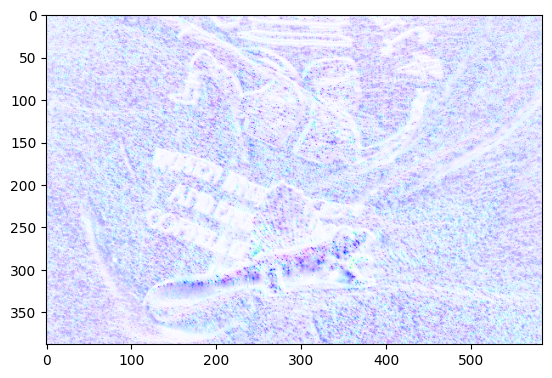

In [1]:
from src.lk_hs.horn_shunck import hs

img1 = "dataset/other-data-color/Dimetrodon/frame10.png"
img2 = "dataset/other-data-color/Dimetrodon/frame11.png"

u, v = hs(img_t=img1, img_t1=img2, multi_channel=True)

from src.representation.colorwhele import visualize_flow
visualize_flow(u=u, v=v)